# LangGraph 기반 검색 에이전트

VectorDB와 웹 검색을 결합한 ReAct 방식의 하이브리드 검색 에이전트입니다.

## 주요 기능
1. ReAct 패턴 (Thought-Action-Observation)
2. 검색 결과 평가 및 재시도
3. 하이브리드 검색 (VectorDB + 웹)
4. 대화 기록 유지

In [ ]:
# !pip install langchain-openai langchain-community langgraph chromadb pymupdf tavily-python langgraph-checkpoint-sqlite -q

## 1. 환경 설정

In [1]:
import os
import getpass

try:
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
    print("Colab Secrets에서 API 키를 불러왔습니다.")

except (ImportError, KeyError):
    openai_key = getpass.getpass("OpenAI API 키: ")
    os.environ["OPENAI_API_KEY"] = openai_key
    tavily_key = getpass.getpass("Tavily API 키: ")
    os.environ["TAVILY_API_KEY"] = tavily_key
    print("API 키가 입력되었습니다.")

API 키가 입력되었습니다.


In [ ]:
import json
import sqlite3
import subprocess
from pathlib import Path
from typing import TypedDict, Annotated, List

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
import operator

/Users/ogeuncheol/Documents/project/ADK/agent_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## 2. PDF 다운로드 및 VectorDB 검색기 도구와 웹검색 도구 설정

In [ ]:

pdf_path = "d2l-en.pdf"
url = "https://d2l.ai/d2l-en.pdf"

if not Path(pdf_path).exists():
    print("PDF 다운로드 중...")
    !curl -L -o $pdf_path $url
    print("다운로드 완료")
else:
    print(f"PDF 파일 존재: {pdf_path}")


PDF 파일 존재: d2l-en.pdf


In [5]:
chroma_db_path = "./chroma_db_d2l"

if Path(chroma_db_path).exists():
    print("기존 DB 로드...")
    vectorstore = Chroma(persist_directory=chroma_db_path, embedding_function=embeddings)
else:
    print("새 DB 생성...")
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()[:100]
    print(f"{len(documents)} 페이지 로드")

    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = splitter.split_documents(documents)
    print(f"{len(chunks)}개 청크 생성")

    print("임베딩 생성 중...")
    vectorstore = Chroma.from_documents(chunks, embeddings, persist_directory=chroma_db_path)
    print("완료")

기존 DB 로드...


/var/folders/g1/cbry4h353tj5gxg9tjrsv4f40000gn/T/ipykernel_22441/3111986772.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=chroma_db_path, embedding_function=embeddings)


In [ ]:
vectordb_retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
web_search_tool = TavilySearchResults(max_results=3)

/var/folders/g1/cbry4h353tj5gxg9tjrsv4f40000gn/T/ipykernel_22441/1235163130.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(max_results=3)


## 3. State 및 노드 정의

In [7]:
class AgentState(TypedDict):
    messages: Annotated[List, operator.add]
    question: str
    current_query: str
    search_method: str
    search_results: str
    is_relevant: bool
    iteration: int
    final_answer: str

def format_history(messages: List[BaseMessage]) -> str:
    if not messages:
        return ""
    history = "\n이전 대화:\n"
    for msg in messages[-6:]:
        role = "사용자" if isinstance(msg, HumanMessage) else "AI"
        history += f"{role}: {msg.content[:200]}...\n"
    return history

In [8]:
def thought_node(state: AgentState):
    print("\n[Thought] 검색 전략 수립...")
    
    question = state["question"]
    iteration = state.get("iteration", 0)
    messages = state.get("messages", [])
    
    context = format_history(messages)
    if iteration > 0:
        context += f"\n이전 시도 실패, 다시 시도 필요\n"
    
    prompt = f"{context}\n질문: {question}\n\n검색 방법 선택 (vectordb: 딥러닝 교과서, websearch: 웹)\nJSON으로 답변: {{\"search_method\": \"vectordb/websearch\", \"query\": \"검색어\", \"reasoning\": \"이유\"}}"
    
    response = llm.invoke([SystemMessage(content=prompt)])
    
    try:
        result = json.loads(response.content)
        method = result.get("search_method", "websearch")
        query = result.get("query", question)
        print(f"방법: {method}, 쿼리: {query}")
        return {"search_method": method, "current_query": query, "iteration": iteration + 1}
    except:
        print("파싱 실패, 기본값 사용")
        return {"search_method": "websearch", "current_query": question, "iteration": iteration + 1}

In [9]:
def action_node(state: AgentState):
    print("\n[Action] 검색 수행...")
    
    method = state["search_method"]
    query = state["current_query"]
    
    if method == "vectordb":
        print(f"  VectorDB: '{query}'")
        docs = vectordb_retriever.invoke(query)
        results = "\n\n".join([doc.page_content for doc in docs])
        print(f"{len(docs)}개 문서 검색")
    else:
        print(f"  웹검색: '{query}'")
        search_results = web_search_tool.invoke(query)
        results = "\n\n".join([f"[{r.get('title')}]\n{r.get('content')}" for r in search_results])
        print("검색 완료")
    
    return {"search_results": results}

In [10]:
def observation_node(state: AgentState):
    print("\n[Observation] 결과 평가...")
    
    question = state["question"]
    results = state["search_results"]
    iteration = state.get("iteration", 0)
    
    eval_prompt = f"""검색 결과가 질문에 답할 수 있는지 평가:
질문: {question}
검색 결과: {results[:500]}...

JSON으로 답변: {{\"is_relevant\": true/false, \"reason\": \"이유\", \"suggestion\": \"제안\"}}"""
    
    eval_response = llm.invoke([SystemMessage(content=eval_prompt)])
    
    try:
        eval_result = json.loads(eval_response.content)
        is_relevant = eval_result.get("is_relevant", False)
        print(f"평가: {'관련 있음' if is_relevant else '관련 없음'}")
        
        if not is_relevant and iteration < MAX_ITERATIONS:
            print(f"재시도 ({iteration}/{MAX_ITERATIONS})")
            return {"is_relevant": False}
        
        print("답변 생성...")
        messages = state.get("messages", [])
        answer_prompt = f"{format_history(messages)}\n질문: {question}\n검색 결과: {results}\n\n위 결과로 답변하세요."
        response = llm.invoke([SystemMessage(content=answer_prompt)])
        
        return {
            "is_relevant": True,
            "final_answer": response.content,
            "messages": [HumanMessage(content=question), AIMessage(content=response.content)]
        }
    except:
        return {"is_relevant": True, "final_answer": "오류 발생", "messages": []}

## 4. 그래프 구성

In [11]:
MAX_ITERATIONS = 5
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn=conn)

def should_continue(state: AgentState) -> str:
    is_relevant = state.get("is_relevant", False)
    iteration = state.get("iteration", 0)
    return "end" if (is_relevant or iteration >= MAX_ITERATIONS) else "continue"

In [12]:
workflow = StateGraph(AgentState)

workflow.add_node("thought", thought_node)
workflow.add_node("action", action_node)
workflow.add_node("observation", observation_node)

workflow.set_entry_point("thought")
workflow.add_edge("thought", "action")
workflow.add_edge("action", "observation")
workflow.add_conditional_edges(
    "observation",
    should_continue,
    {"continue": "thought", "end": END}
)

search_agent = workflow.compile(checkpointer=memory)

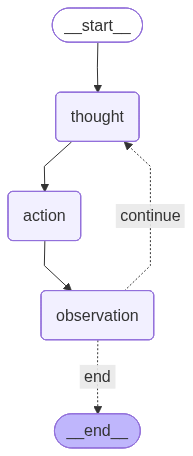

In [13]:
search_agent

## 5. 실행 함수

In [16]:
def run_agent(question: str, thread_id: str = "default", agent: StateGraph = search_agent):
    print("\n" + "=" * 60)
    print(f"질문: {question}")
    print("=" * 60)
    
    config = {"configurable": {"thread_id": thread_id}}
    
    try:
        current_state = agent.get_state(config)
        existing_messages = current_state.values.get("messages", []) if current_state.values else []
    except:
        existing_messages = []
    
    initial_state = {
        "question": question,
        "current_query": question,
        "messages": existing_messages,
        "search_method": "",
        "search_results": "",
        "is_relevant": False,
        "iteration": 0,
        "final_answer": ""
    }
    
    result = agent.invoke(initial_state, config=config)
    
    print("\n" + "=" * 60)
    print("최종 답변:")
    print("=" * 60)
    print(result["final_answer"])
    print(f"\n총 반복: {result['iteration']}")
    
    return result

## 6. 테스트

In [18]:
# 테스트 1: VectorDB 검색
result1 = run_agent("경사 하강법(gradient descent)이란 무엇인가요?")


질문: 경사 하강법(gradient descent)이란 무엇인가요?

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: 경사 하강법(gradient descent) 정의

[Action] 검색 수행...
  VectorDB: '경사 하강법(gradient descent) 정의'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 있음
답변 생성...

최종 답변:
경사 하강법(Gradient Descent)은 함수의 최솟값을 찾기 위한 최적화 알고리즘입니다. 이 방법은 함수의 기울기(경사)를 계산하고, 그 기울기의 반대 방향으로 이동하여 함수의 값을 최소화하는 방식으로 작동합니다. 즉, 각 독립변수의 값을 조정하면서 함수의 값이 낮아지는 방향으로 탐색하는 방법입니다.

경사 하강법은 머신 러닝에서 모델의 파라미터를 최적화하는 데 널리 사용됩니다. 이 과정에서 손실 함수의 기울기를 계산하여, 파라미터를 업데이트하는 방식으로 작동합니다. 기울기는 함수의 변화율을 나타내며, 이를 통해 파라미터를 어떻게 조정해야 손실을 줄일 수 있는지를 결정할 수 있습니다.

경사 하강법은 단일 변수에 대한 경우와 다변수에 대한 경우로 나눌 수 있으며, 다양한 변형이 존재합니다. 예를 들어, 확률적 경사 하강법(Stochastic Gradient Descent, SGD)은 전체 데이터셋 대신 무작위로 선택된 샘플을 사용하여 기울기를 계산하는 방법입니다. 이러한 방식은 계산 효율성을 높이고, 더 빠른 수렴을 도울 수 있습니다. 

경사 하강법은 딥러닝과 같은 복잡한 최적화 문제에서도 중요한 역할을 하며, 다양한 적응형 방법(Adaptive Methods)도 개발되어 사용되고 있습니다.

총 반복: 1


In [20]:
# 테스트 2: 웹 검색
result2 = run_agent("2025년 노벨상은 누가 수상했나요?")


질문: 2025년 노벨상은 누가 수상했나요?

[Thought] 검색 전략 수립...
방법: websearch, 쿼리: 2025 Nobel Prize winners

[Action] 검색 수행...
  웹검색: '2025 Nobel Prize winners'
검색 완료

[Observation] 결과 평가...
평가: 관련 있음
답변 생성...

최종 답변:
2025년 노벨상 수상자는 다음과 같습니다:

- **생리학 또는 의학상**: 메리 E. 브룩코우, 프레드 램스델, 시몬 사카구치 (면역 시스템 관련 연구)
- **물리학상**: 존 클락, 미셸 H. 드보레, 존 M. 마르티니스 (대규모 전기 시스템에서 양자역학 이해 증진)
- **화학상**: 스스무 키타가와, 리처드 롭슨, 오마르 M. 야기 (금속-유기 프레임워크 개발)
- **문학상**: 라슬로 크라즈나호르카이 (헝가리)
- **평화상**: 발표 예정
- **경제학상**: 발표 예정

이 정보는 2025년 10월 기준으로 확인된 내용입니다.

총 반복: 1


In [21]:
# 테스트 3: 대화 컨텍스트 유지
result3 = run_agent("activation function이란?", thread_id="test")
result4 = run_agent("그것의 종류는?", thread_id="test")


질문: activation function이란?

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: activation function

[Action] 검색 수행...
  VectorDB: 'activation function'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 없음
재시도 (1/5)

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: activation function

[Action] 검색 수행...
  VectorDB: 'activation function'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 없음
재시도 (2/5)

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: activation function

[Action] 검색 수행...
  VectorDB: 'activation function'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 없음
재시도 (3/5)

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: activation function

[Action] 검색 수행...
  VectorDB: 'activation function'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 없음
재시도 (4/5)

[Thought] 검색 전략 수립...
방법: vectordb, 쿼리: activation function

[Action] 검색 수행...
  VectorDB: 'activation function'
3개 문서 검색

[Observation] 결과 평가...
평가: 관련 없음
답변 생성...

최종 답변:
Activation function은 인공 신경망에서 뉴런의 출력을 결정하는 수학적 함수입니다. 이 함수는 입력 신호의 가중합을 받아서 비선형성을 추가하여 뉴런의 활성화 여부를 결정합니다. 즉, 입력값이 특정 임계값을 초과할 때 뉴런